In [ ]:
# function for DESeq2 analysis
# this function only analyses based on a 'condition' parameter for the design.
# input:
#   input.counts: data.frame with counts and gene IDs as rownames
#   input.cols. data.frame with conditions and samples as rownames
# output:
#   data.frame containing DESeq2 analysis results.
deseq2_analysis <- function(input.counts, input.cols){
    # function body
    dds <- DESeqDataSetFromMatrix(countData = input.counts,
                              colData = input.cols,
                              design = ~ condition)
    dds <- DESeq(dds)
    res <- results(dds)
    res.df <- as.data.frame(res)
    return(res.df)
}

Below is an outline for how one might extract the information of chromosome 1 from our DESeq2 results

The first step is to remember that we already have everything we need to do this. The gene IDs used as row names in the output from DESeq2 is originally from the .gtf file we got from ENCODE

When looking at the [documentation](http://www.gencodegenes.org/gencodeformat.html) for ENCODE .gtf files we can see that it would be useful to extract columns 1, 3, 4, and 9. However, when inspecting the .gtf file a few things shuld be noticed.

First, the file has some beginning lines which will throw off any file reader which looks for a specific format. Second, the additional information in the .gtf file is no longer tab-delimited but has different separation rules. One way to deal with this is a two step approach where first the beginning of the file is removed, followed by extracting all lines which contain the keyword 'chr1'. 

In [ ]:
%%bash

cd ~/scratch/annotations/hg19

# remove the first few lines using the 'tail' command. Additionally, use the 'pipe' to also extract only the columns of interest
tail -n +6 gencode.v19.annotation.gtf | cut -f 1,3,4,9 > gencode_filtered.gtf

# extract only rows containing 'chr1'. (note, the -w flag enforces a direct match. Else we would also get partial matches with chr10, chr11 etc.)
grep -w 'chr1' gencode_filtered.gtf > gencode_chr1.gtf

# since the format of column 9 is different from the other 2 we create two separate files which will individually be easier to process
cut -f 1,2,3 gencode_chr1.gtf > gencode_chr1_pos.gtf
cut -f4 gencode_chr1.gtf > gencode_chr1_info.gtf

# lastly, make sure that your final files look as expected. Comparing the relative number of lines between the original file
# and the chromosome 1 files we see that the new files have about 1/10 as many lines which matches our expectations
wc -l gencode_filtered.gtf
wc -l gencode_chr1.gtf


Although we reduced the amount of data to deal with by quite a bit we still can do better. from the 'gencode_chr1_info.gtf' we only need the gene ID. Here we use Python to quickly parse the file:

In [ ]:
%%python

# read in file and extract the gene ID information
info_file = open('gencode_chr1_info.gtf', 'r')
out_ids = []
for line in info_file:
	row_info = line.split(';')[0].split(' ')[1][1:-1]
	out_ids.append(row_info)

# write all gene IDs to a .csv file which is easy to read into R
outfile = open('gencode_chr1_IDs.csv', 'w')
for i in range(0, len(out_ids)):
	to_write = out_ids[i] + '\n'
	outfile.write(to_write)
	
outfile.close()

The above should run very fast (try running the same oprations in R and you will see why we did it in Python). Now we are ready to start extracting our DESeq2 results for chromosome 1. Since we want to save all our files in the DESeq2 directory make sure you move there first

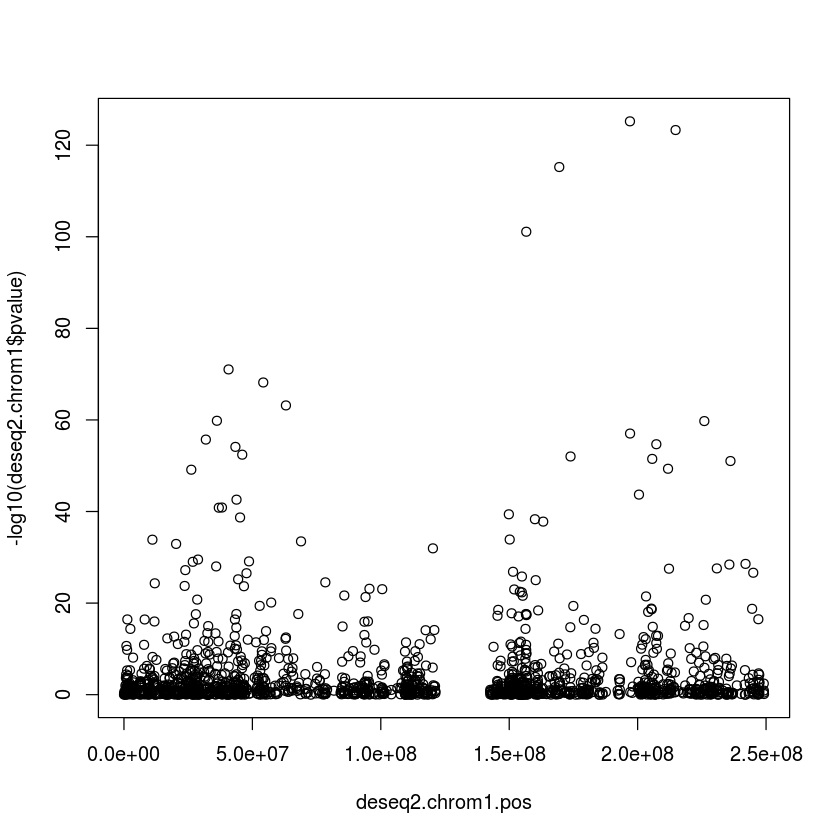

In [9]:
# read in all files
chr1.pos.gtf <- read.delim('~/scratch/annotations/hg19/gencode_chr1_pos.gtf', header = FALSE, stringsAsFactors = FALSE)
chr1.ids <- read.csv('~/scratch/annotations/hg19/gencode_chr1_IDs.csv', header = FALSE, stringsAsFactors = FALSE)
deseq2.results <- read.csv('~/projects/tardbp_shrna/deseq2/tardbp_deseq2_results.csv', header = TRUE, row.names = 1)
deseq2.ids <- rownames(deseq2.results)

# combine chromosome 1 info
chr1.info <- cbind(chr1.pos.gtf, chr1.ids)
colnames(chr1.info) <- c('chr', 'feature', 'start_pos', 'gene_id')

# extract genes only
chr1.gene.info <- chr1.info[chr1.info$feature == 'gene',]

# extract all rows from the DEseq2 output which haev a chromosome 1 associated ID
deseq2.chrom1 <- deseq2.results[which(deseq2.ids %in% chr1.gene.info$gene_id),]

# below creates a list ith the ID as name and the position as value
geneID.pos <- as.list(setNames(chr1.gene.info$start_pos, chr1.gene.info$gene_id))

# extract the coordinates for the DESeq2 chromosome 1 results
deseq2.chrom1.pos <- unlist(geneID.pos[rownames(deseq2.chrom1)])

plot(x = deseq2.chrom1.pos, y = -log10(deseq2.chrom1$pvalue))

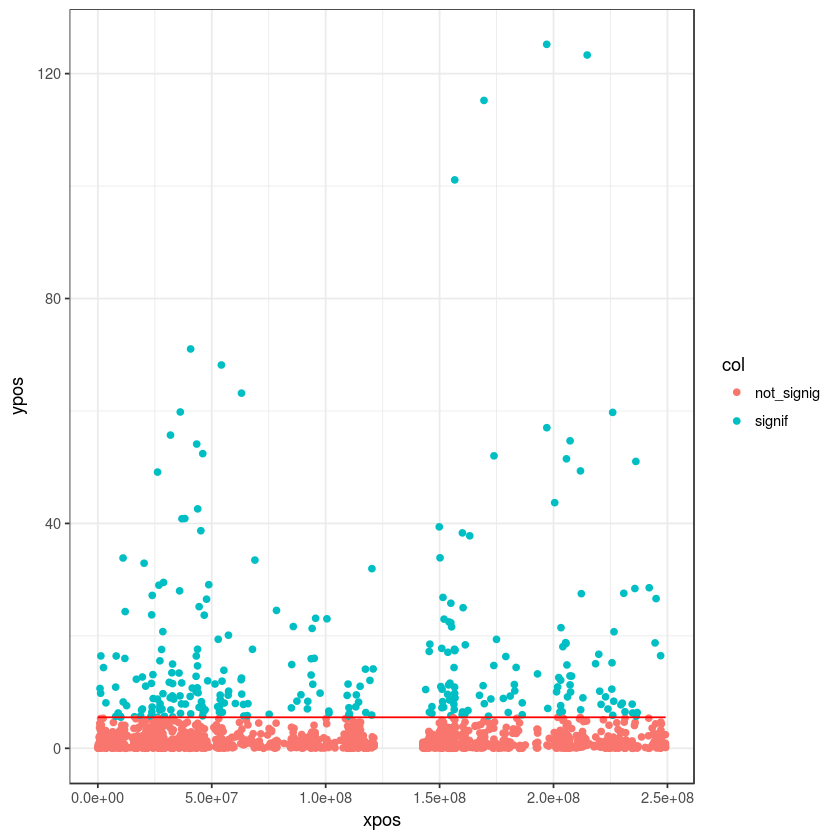

In [10]:
# we can also use ggplot to create plots instead. 
#Generally ggplot is more flexible and has more capabilities than Rs default plotting function
library(ggplot2)

# create Bonferroni corrected p-value threshold:
bonf.thresh <- 0.05 / nrow(deseq2.results)

# we want to add some color. Significant genes get colored red
gene.colors <- rep('not_signig', length(deseq2.chrom1.pos))
gene.colors[deseq2.chrom1$pvalue < bonf.thresh] <- 'signif'

#format the data: ggplot expects a data frame
format.data <- cbind.data.frame(xpos = deseq2.chrom1.pos, ypos = -log10(deseq2.chrom1$pvalue), col = gene.colors)

# and how about making the p-value cutoff visible
p.cutoff <- cbind.data.frame(pos = c(min(format.data$xpos), max(format.data$xpos)),
                            val = c(-log10(bonf.thresh), -log10(bonf.thresh)))

chrom1.plot <- ggplot()+
    geom_point(data = format.data, aes(x = xpos, y = ypos, colour = col)) +
    geom_line(data = p.cutoff, aes(x = pos, y = val), ,colour = 'red') + 
    theme_bw() 

print(chrom1.plot)